In [3]:
import pandas as pd

# Load the Excel file
data = pd.read_excel('data.xlsx')  # Adjust sheet name if needed

# Display the first few rows
print(data.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
for column in data.columns:
    print(f"Column: {column}, Type: {data[column].dtype}")



Column: InvoiceNo, Type: object
Column: StockCode, Type: object
Column: Description, Type: object
Column: Quantity, Type: int64
Column: InvoiceDate, Type: datetime64[ns]
Column: UnitPrice, Type: float64
Column: CustomerID, Type: float64
Column: Country, Type: object


In [63]:
# Create the 'TotalSpend' feature (Quantity * UnitPrice)
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']

# Convert 'InvoiceDate' to datetime format (if not already)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate 'Recency' (number of days since the latest invoice date)
latest_invoice_date = data['InvoiceDate'].max()
data['Recency'] = (latest_invoice_date - data['InvoiceDate']).dt.days

# Drop any rows with missing data for simplicity
data = data.dropna(subset=['TotalSpend', 'Quantity', 'Recency'])

# Export the cleaned data to a new Excel file
output_file = "cleaned_data.xlsx"  # You can modify the file name as needed
data.to_excel(output_file, index=False)

# Display the new columns and the first few rows
print(data[['TotalSpend', 'Quantity', 'Recency']].head(100))


    TotalSpend  Quantity  Recency
0        15.30         6      373
1        20.34         6      373
2        22.00         8      373
3        20.34         6      373
4        20.34         6      373
..         ...       ...      ...
95       15.30         6      373
96       50.40       120      373
97       13.20        24      373
98       13.20        24      373
99       13.20        24      373

[100 rows x 3 columns]


In [6]:
# Select features for clustering
features_for_scaling = ['TotalSpend', 'Quantity', 'Recency']


In [23]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features_for_scaling])

# Check the scaled data
print(X_scaled[:5])


[[-0.00709536 -0.01628867  1.86046242]
 [ 0.00620945 -0.01628867  1.86046242]
 [ 0.01059159 -0.00711777  1.86046242]
 [ 0.00620945 -0.01628867  1.86046242]
 [ 0.00620945 -0.01628867  1.86046242]]


In [69]:
from sklearn.cluster import KMeans

# Apply KMeans with 4 clusters (adjust as needed)
kmeans = KMeans(n_clusters=7, random_state=42)
data['Segment_KMeans'] = kmeans.fit_predict(X_scaled)

# Display the cluster sizes
print("Cluster Sizes:")

# print(data['Segment_KMeans'].value_counts())
print(" data point:  " ,  data['Segment_KMeans'])


Cluster Sizes:
Segment_KMeans
3    196555
6    120705
0    115161
4    109484
2         2
5         1
1         1
Name: count, dtype: int64
 data point:   0         4
1         4
2         4
3         4
4         4
         ..
541904    3
541905    3
541906    3
541907    3
541908    3
Name: Segment_KMeans, Length: 541909, dtype: int32


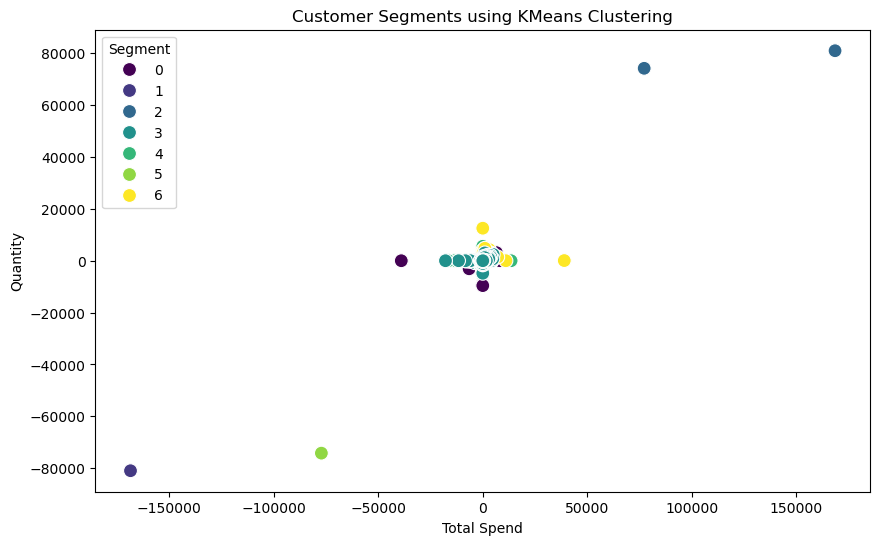

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize KMeans clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='TotalSpend', y='Quantity', hue='Segment_KMeans', palette='viridis', s=100, marker='o')
plt.title('Customer Segments using KMeans Clustering')
plt.xlabel('Total Spend')
plt.ylabel('Quantity')
plt.legend(title='Segment')
plt.show()


In [33]:
# Investigate the cluster characteristics
segment_stats = data.groupby('Segment_KMeans')[['TotalSpend', 'Quantity', 'Recency']].mean()
print(segment_stats)


                   TotalSpend      Quantity     Recency
Segment_KMeans                                         
0                   17.516672      9.309080  228.397192
1              -168469.600000 -80995.000000    0.000000
2               122826.600000  77605.000000  162.500000
3                   17.131961      8.944499   36.085167
4                   17.339546      8.856235  331.239880
5               -77183.600000 -74215.000000  325.000000
6                   20.419493     11.405534  129.547152


DBSCAN Cluster Sizes:
Segment_DBSCAN
 0    5580
-1    3864
 1     556
Name: count, dtype: int64


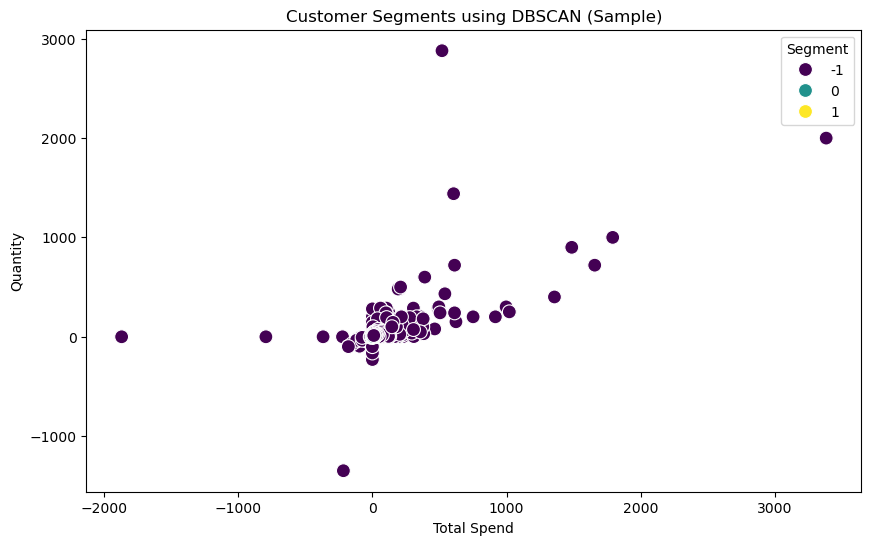

In [59]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Sample 50,000 rows from the data
data_sample = data.sample(n=10000, random_state=42)
X_scaled_sample = scaler.fit_transform(data_sample[features_for_scaling])

# Apply DBSCAN on the smaller sample with adjusted parameters
dbscan = DBSCAN(eps=0.1, min_samples=100)  # Adjust eps and min_samples as needed
data_sample['Segment_DBSCAN'] = dbscan.fit_predict(X_scaled_sample)

# Display the cluster sizes
print("DBSCAN Cluster Sizes:")
print(pd.Series(data_sample['Segment_DBSCAN']).value_counts())

# Visualize the DBSCAN result for the smaller sample
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_sample, x='TotalSpend', y='Quantity', hue='Segment_DBSCAN', palette='viridis', s=100, marker='o')
plt.title('Customer Segments using DBSCAN (Sample)')
plt.xlabel('Total Spend')
plt.ylabel('Quantity')
plt.legend(title='Segment')
plt.show()


Cluster Sizes:
Segment_GMM
4    243556
3    183619
6     98755
0     15975
2         2
5         1
1         1
Name: count, dtype: int64


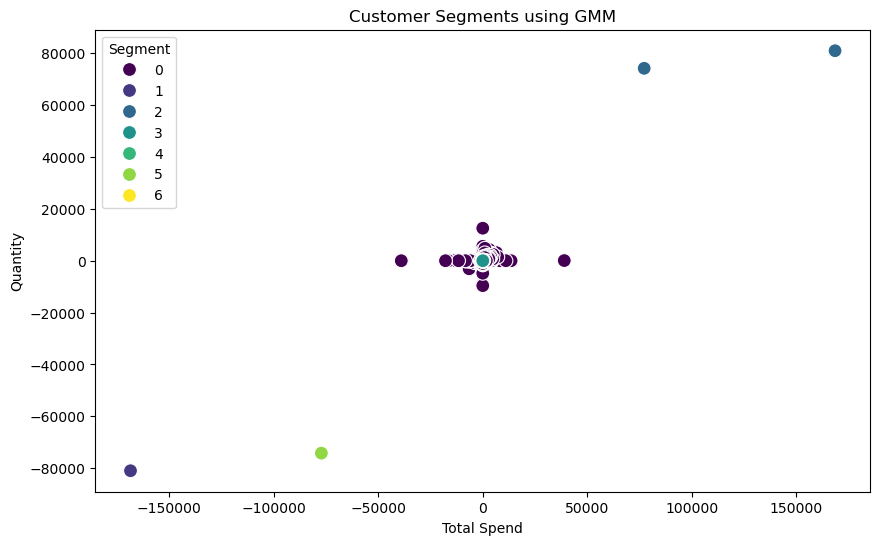

In [61]:
from sklearn.mixture import GaussianMixture

# Apply GMM clustering
gmm = GaussianMixture(n_components=7, random_state=42)
data['Segment_GMM'] = gmm.fit_predict(X_scaled)


# Print the number of data points in each cluster
cluster_sizes = data['Segment_GMM'].value_counts()
print("Cluster Sizes:")
print(cluster_sizes)

# Visualize GMM clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='TotalSpend', y='Quantity', hue='Segment_GMM', palette='viridis', s=100, marker='o')
plt.title('Customer Segments using GMM')
plt.xlabel('Total Spend')
plt.ylabel('Quantity')
plt.legend(title='Segment')
plt.show()


In [62]:
import joblib


joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(dbscan, 'dbscan_model.pkl')
joblib.dump(gmm, 'gmm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [19]:
from sklearn.metrics import silhouette_score
silhouette_kmeans = silhouette_score(X_scaled, data['Segment_KMeans'])
silhouette_dbscan = silhouette_score(X_scaled_sample, data_sample['Segment_DBSCAN'])
silhouette_gmm = silhouette_score(X_scaled, data['Segment_GMM'])
print("Silhouette Score (KMeans):", silhouette_kmeans)
print("Silhouette Score (DBSCAN):", silhouette_dbscan)
print("Silhouette Score (GMM):", silhouette_gmm)


KeyboardInterrupt: 